# Autoregressive moving average

## Install packages

In [3]:
import sys
!{sys.executable} -m pip install -r requirements.txt

    100% |████████████████████████████████| 7.4MB 3.8MB/s eta 0:00:01 0% |▎                               | 71kB 2.8MB/s eta 0:00:03    28% |█████████                       | 2.1MB 20.6MB/s eta 0:00:01
    100% |████████████████████████████████| 12.2MB 2.9MB/s eta 0:00:01   25% |████████▏                       | 3.1MB 32.2MB/s eta 0:00:01    38% |████████████▏                   | 4.6MB 31.5MB/s eta 0:00:01    72% |███████████████████████▍        | 8.9MB 30.2MB/s eta 0:00:01
    100% |████████████████████████████████| 26.2MB 1.4MB/s eta 0:00:01  4% |█▍                              | 1.2MB 27.0MB/s eta 0:00:01    30% |█████████▊                      | 8.0MB 27.7MB/s eta 0:00:01    45% |██████████████▋                 | 12.0MB 29.7MB/s eta 0:00:01
    100% |████████████████████████████████| 1.1MB 17.6MB/s ta 0:00:01
    100% |████████████████████████████████| 50.0MB 754kB/s eta 0:00:01  7% |██▎                             | 3.6MB 25.7MB/s eta 0:00:02    9% |███▏                           

In [4]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import seaborn as sns
import quiz_tests

In [5]:
sns.set()
#note that for the figure size to show, this cell should be run
#separately from the import of pyplot
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## Simulate return series with autoregressive properties

In [6]:
from statsmodels.tsa.arima_process import ArmaProcess
np.random.seed(200)

ar_params = np.array([1, -0.5])
ma_params = np.array([1, -0.3])
ret = ArmaProcess(ar_params, ma_params).generate_sample(nsample=5*252)

ret = pd.Series(ret)
drift = 100
price = pd.Series(np.cumsum(ret)) + drift

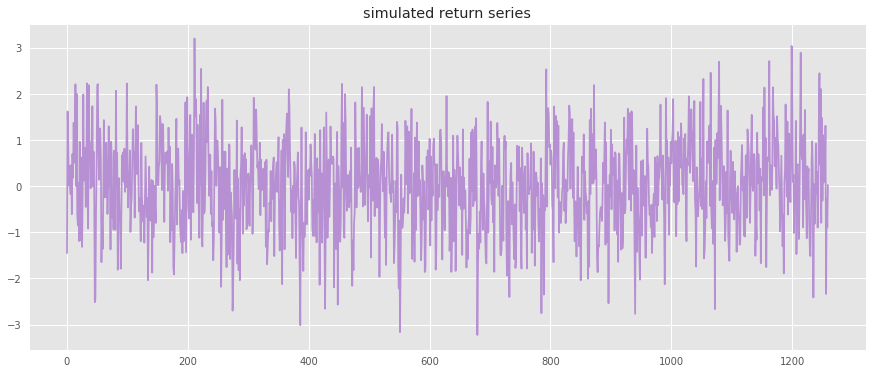

In [7]:
ret.plot(figsize=(15,6), color=sns.xkcd_rgb["pale purple"], title="simulated return series")
plt.show()

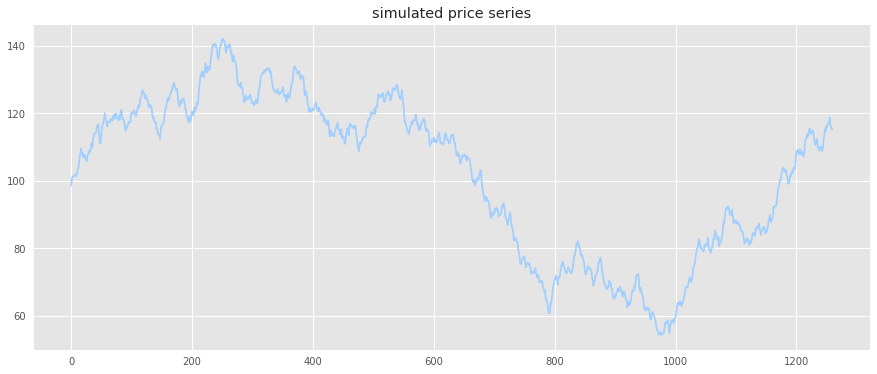

In [8]:
price.plot(figsize=(15,6), color=sns.xkcd_rgb["baby blue"], title="simulated price series")
plt.show()

### log returns

In [9]:
lret = np.log(price) - np.log(price.shift(1))
lret = lret[1:]

## autocorrelation

Use autocorrelation to get a sense of what lag to use for the autoregressive model.  

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

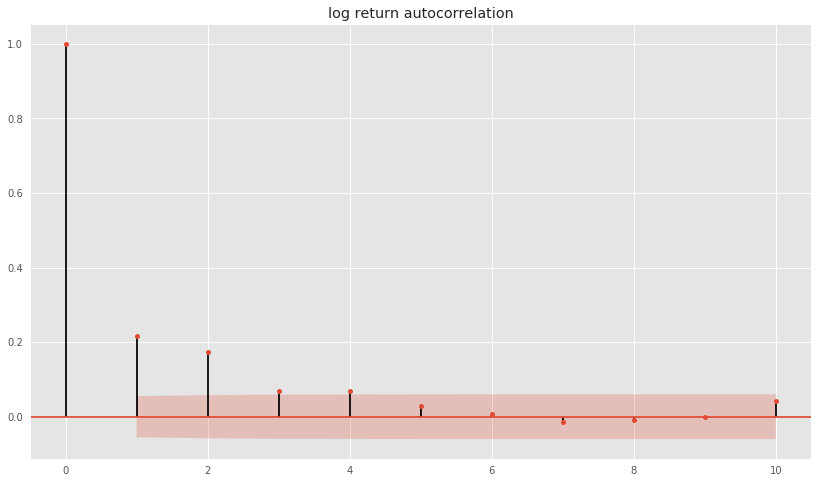

In [11]:
_ = plot_acf(lret,lags=10, title='log return autocorrelation')

Since the sample series was simulated to have autoregressive properties, we also see autocorrelation between the current periods and the lags.

Note that with actual stock data, there won't be much autocorrelation of returns from one day to the next.  
Stock returns (log returns and normal returns) can be described as a "random walk", in that each new period's value is more or less random.

## plot partial autocorrelation

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

Notice how the partial autocorrelation of price shows that most of the correlation is found in the previous period.  Partial autocorrelation is different from autocorrelation in that it shows the influence of each period that is not attributed to the other periods leading up to the current period.  In other words, the two-day lag had a fairly strong correlation with the current value because it had a strong correlation with the one-day lag. However, the two-day lag's partial correlation with the current period that isn't attributable to the one-day lag is relatively small.

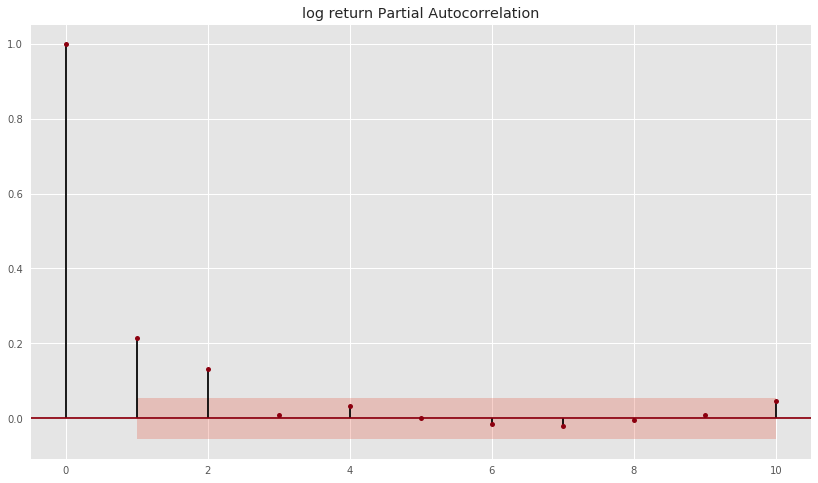

In [13]:
_ = plot_pacf(lret, lags=10, title='log return Partial Autocorrelation', color=sns.xkcd_rgb["crimson"])

## Discussion

Notice that there isn't much correlation between previous periods with the current period.  In general, using past stock returns to predict future stock returns is rather difficult.  Volatility tends to have more of a correlation with past volatility.  We'll cover volatility in a later lesson within this module.

## Ljung-Box Test

The Ljung-Box test helps us check whether the lag we chose gives autocorrelations that are significantly different from zero.  The null hypothesis is that the previous lags as a whole are not correlated with the current period.  If the p-value is small enough (say 0.05), we can reject the null and assume that the past lags have some correlation with the current period.

```

returns:
lbvalue (float or array) – test statistic
pvalue (float or array) – p-value based on chi-square distribution
... (we'll ignore the other outputs, which are for another similar hypothesis test)
```

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [15]:
lb_test_stat, lb_p_value = acorr_ljungbox(lret,lags=20)
lb_p_value

array([  2.01640711e-14,   1.24123312e-21,   5.10501473e-22,
         1.86446247e-22,   6.13688232e-22,   2.96811370e-21,
         1.18392407e-20,   4.64232373e-20,   1.78935377e-19,
         2.36770725e-19,   5.54712773e-19,   1.32980392e-18,
         3.72359442e-18,   5.86709112e-18,   1.72205886e-17,
         4.22143078e-17,   1.15704571e-16,   9.89290170e-17,
         2.59299780e-16,   1.50593115e-16])

## Discussion

Since this series was simulated to have autoregressive properties, the Ljung-Box test shows p-values less than 0.05 for the 20 lag periods that we tested.

## Fit an ARMA model

For the purpose of familiarizing ourselves with the ARMA model, we'll fit the model to our simulated return series.

We'll just use one lag for the autoregression and one lag for the moving average.  
Check out the [statsmodel arma](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMA.html) documentation.

In [16]:
from statsmodels.tsa.arima_model import ARMA

In [17]:
AR_lag_p = 1
MA_lag_q = 1
order = (AR_lag_p, MA_lag_q)
arma_model = ARMA(lret.values, order=order)
arma_result = arma_model.fit()
arma_pred = pd.Series(arma_result.fittedvalues)

## View fitted predictions against actual values

Fitted AR parameter 0.65, MA parameter -0.45


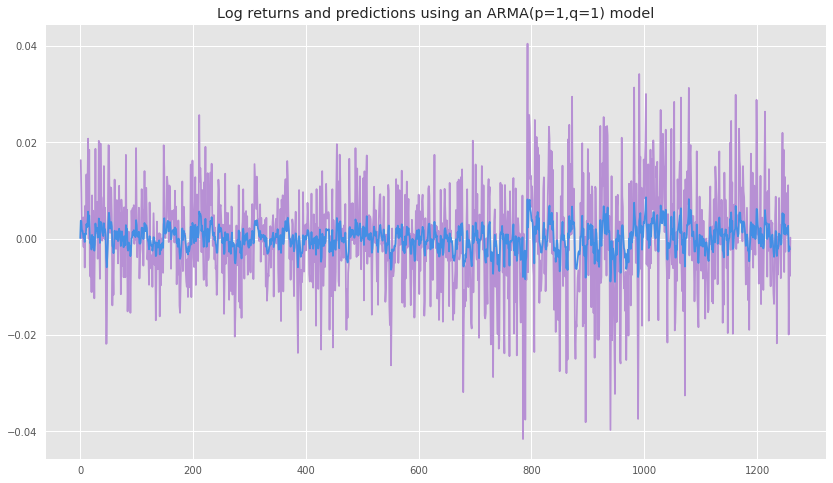

In [18]:
plt.plot(lret, color=sns.xkcd_rgb["pale purple"])
plt.plot(arma_pred, color=sns.xkcd_rgb["dark sky blue"])
plt.title('Log returns and predictions using an ARMA(p=1,q=1) model');
print(f"Fitted AR parameter {arma_result.arparams[0]:.2f}, MA parameter {arma_result.maparams[0]:.2f}")

## Discussion

In general, autoregressive moving average models are not able to forecast stock returns because stock returns are non-stationary and also quite noisy.

There are other techniques that build upon the concepts of ARMA models, so the goal here was really to help you get familiar with these concepts, as they are the basis for other models that you'll see later in this module.

## Quiz: ARIMA

Fit an autoregressive integrated moving average model.  Choose an order of integration of 1, autoregresion lag of 1, and moving average lag of 1.

Check out the [stats model arima](http://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.arima_model.ARMAResults.html) documentation to help you.

In [19]:
from statsmodels.tsa.arima_model import ARIMA

In [26]:
def fit_arima(lret):
    
    #TODO: choose autoregression lag of 1
    AR_lag_p = 1
    p = AR_lag_p
    #TODO: choose moving average lag of 1
    MA_lag_q = 1
    q = MA_lag_q
    #TODO: choose order of integration 1
    order_of_integration_d = 1
    d = order_of_integration_d
    #TODO: Create a tuple of p,d,q
    order = (p, d, q)
    
    #TODO: create an ARIMA model object, passing in the values of the lret pandas series,
    # and the tuple containing the (p,d,q) order arguments
    arima_model = ARIMA(lret.values, order=order)
    
    arima_result = arima_model.fit()
    
    #TODO: from the result of calling ARIMA.fit(),
    # save and return the fitted values, autoregression parameters, and moving average parameters
    fittedvalues = arima_result.fittedvalues
    arparams = arima_result.arparams
    maparams = arima_result.maparams
   
    return fittedvalues,arparams,maparams

quiz_tests.test_fit_arima(fit_arima)

Tests Passed


fitted AR parameter 0.21, MA parameter -0.98


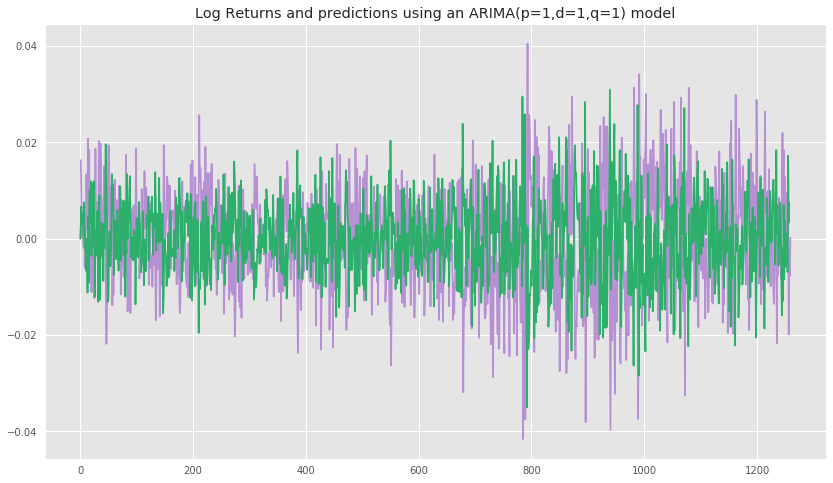

In [27]:
fittedvalues,arparams,maparams = fit_arima(lret)
arima_pred = pd.Series(fittedvalues)
plt.plot(lret, color=sns.xkcd_rgb["pale purple"])
plt.plot(arima_pred, color=sns.xkcd_rgb["jade green"])
plt.title('Log Returns and predictions using an ARIMA(p=1,d=1,q=1) model');
print(f"fitted AR parameter {arparams[0]:.2f}, MA parameter {maparams[0]:.2f}")

If you're stuck, you can also check out the solution [here](autoregression_solution.ipynb)